## Vision Transformer + Random Forest Classifier

### Trained on default data

In [1]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
from torchvision import transforms
from torchvision.models import vit_b_16
from PIL import Image
from tqdm import tqdm
import joblib

# Path to the dataset
data_dir = 'H:/Deep Learning/Pest and Insect Detection/Image Data/train'

# Define the transformation for image preprocessing before passing to ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ViT input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pre-trained ViT
])

# Function to load images from multiple folders and return them as a list
def load_images_from_folders(data_dir, transform=None):
    images = []
    labels = []
    class_labels = os.listdir(data_dir)
    class_dict = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        folder_path = os.path.join(data_dir, label)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('RGB')  # Open the image as RGB
            if transform:
                img = transform(img)  # Apply transformations (e.g., normalization)
            images.append(img)
            labels.append(class_dict[label])
    
    return images, labels

# Load the images
images, labels = load_images_from_folders(data_dir, transform)

# Stack images into a tensor and labels into a numpy array
images_tensor = torch.stack(images)
labels = np.array(labels)

# Load pre-trained Vision Transformer (ViT) model
vit_model = vit_b_16(pretrained=True)
vit_model.eval()  # Set the model to evaluation mode

# Move the model to GPU if available (if not, will run on CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

# Function to extract features from ViT model with batching
def extract_features(images_tensor, model, batch_size=32):
    all_features = []
    num_batches = len(images_tensor) // batch_size + (1 if len(images_tensor) % batch_size != 0 else 0)

    for i in tqdm(range(num_batches)):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(images_tensor))
        batch = images_tensor[start_idx:end_idx].to(device)  # Move batch to GPU if available
        
        with torch.no_grad():  # No need to compute gradients for feature extraction
            outputs = model(batch)  # Pass through ViT
            all_features.append(outputs.cpu().numpy())  # Move features to CPU

    return np.concatenate(all_features, axis=0)

# Extract features from the images in smaller batches
features = extract_features(images_tensor, vit_model, batch_size=32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Save the trained model using joblib
model_path = 'H:/Deep Learning/Pest and Insect Detection/Vision Transformer integrated with ML models/ViT_RF_model.pkl'
joblib.dump(rf_classifier, model_path)
print(f"Model saved to {model_path}")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

c:\Users\HP\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/138 [00:00<?, ?it/s]c:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\activation.py:1230: UserWarning: 1Torch was not compiled with flash att

Model saved to H:/Deep Learning/Pest and Insect Detection/Vision Transformer integrated with ML models/ViT_RF_model.pkl
Accuracy: 0.9180887372013652
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        88
           1       0.96      0.99      0.97        86
           2       0.89      0.76      0.82        72
           3       0.75      0.79      0.77        71
           4       0.88      0.91      0.89        54
           5       0.84      0.82      0.83        79
           6       0.97      0.90      0.93        70
           7       0.91      0.99      0.95        85
           8       0.94      0.89      0.91        53
           9       0.99      1.00      0.99        79
          10       0.95      0.95      0.95        64
          11       0.95      1.00      0.97        78

    accuracy                           0.92       879
   macro avg       0.92      0.91      0.91       879
weighted avg    

### Data Augmentation to increase the number of images for better accuracy

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from tqdm import tqdm

# Path to the dataset
data_dir = 'H:/Deep Learning/Pest and Insect Detection/Image Data/train'
augmented_data_dir = 'H:/Deep Learning/Pest and Insect Detection/Image Data/train_augmented'

# Define the transformation for image augmentation
augment_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.RandomErasing()
])

# Function to load images from folders
def load_images_from_folders(data_dir):
    dataset = ImageFolder(root=data_dir)
    class_dict = {v: k for k, v in dataset.class_to_idx.items()}
    images, labels = [], []
    for img, label in dataset:
        images.append(img)
        labels.append(label)
    return images, labels, class_dict

# Function to save augmented images
def save_augmented_images(images, labels, class_dict, target_num_images):
    if not os.path.exists(augmented_data_dir):
        os.makedirs(augmented_data_dir)

    class_counts = {label: 0 for label in class_dict.keys()}

    for i in tqdm(range(len(images))):
        img, label = images[i], labels[i]
        class_name = class_dict[label]
        class_dir = os.path.join(augmented_data_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        # Save the original image
        img_tensor = transforms.ToTensor()(img)
        save_image(img_tensor, os.path.join(class_dir, f'{class_counts[label]}.png'))
        class_counts[label] += 1

        # Generate and save augmented images
        while class_counts[label] < target_num_images:
            augmented_img_tensor = augment_transforms(img)
            save_image(augmented_img_tensor, os.path.join(class_dir, f'{class_counts[label]}.png'))
            class_counts[label] += 1

# Load images
images, labels, class_dict = load_images_from_folders(data_dir)

# Find the maximum number of images in any class
max_images_per_class = max([labels.count(l) for l in class_dict.keys()])

# Save augmented images ensuring each class has the same number of images
save_augmented_images(images, labels, class_dict, target_num_images=max_images_per_class)

### Training on Augmented Data

In [1]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
from torchvision import transforms
from torchvision.models import vit_b_16
from PIL import Image
from tqdm import tqdm
import joblib

# Path to the dataset
data_dir = 'H:/Deep Learning/Pest and Insect Detection/Image Data/train_augmented'

# Define the transformation for image preprocessing before passing to ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ViT input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pre-trained ViT
])

# Function to load images from multiple folders and return them as a list
def load_images_from_folders(data_dir, transform=None):
    images = []
    labels = []
    class_labels = os.listdir(data_dir)
    class_dict = {label: idx for idx, label in enumerate(class_labels)}

    for label in class_labels:
        folder_path = os.path.join(data_dir, label)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('RGB')  # Open the image as RGB
            if transform:
                img = transform(img)  # Apply transformations (e.g., normalization)
            images.append(img)
            labels.append(class_dict[label])
    
    return images, labels

# Load the images
images, labels = load_images_from_folders(data_dir, transform)

# Stack images into a tensor and labels into a numpy array
images_tensor = torch.stack(images)
labels = np.array(labels)

# Load pre-trained Vision Transformer (ViT) model
vit_model = vit_b_16(pretrained=True)
vit_model.eval()  # Set the model to evaluation mode

# Move the model to GPU if available (if not, will run on CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

# Function to extract features from ViT model with batching
def extract_features(images_tensor, model, batch_size=32):
    all_features = []
    num_batches = len(images_tensor) // batch_size + (1 if len(images_tensor) % batch_size != 0 else 0)

    for i in tqdm(range(num_batches)):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(images_tensor))
        batch = images_tensor[start_idx:end_idx].to(device)  # Move batch to GPU if available
        
        with torch.no_grad():  # No need to compute gradients for feature extraction
            outputs = model(batch)  # Pass through ViT
            all_features.append(outputs.cpu().numpy())  # Move features to CPU

    return np.concatenate(all_features, axis=0)

# Extract features from the images in smaller batches
features = extract_features(images_tensor, vit_model, batch_size=32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Save the trained model using joblib
model_path = 'H:/Deep Learning/Pest and Insect Detection/Vision Transformer integrated with ML models/ViT_RF_model_augmented_data.pkl'
joblib.dump(rf_classifier, model_path)
print(f"Model saved to {model_path}")

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

c:\Users\HP\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/289 [00:00<?, ?it/s]c:\Users\HP\anaconda3\Lib\site-packages\torch\nn\modules\activation.py:1230: UserWarning: 1Torch was not compiled with flash att

Model saved to H:/Deep Learning/Pest and Insect Detection/Vision Transformer integrated with ML models/ViT_RF_model.pkl
Accuracy: 0.9572742022714981
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       172
           1       0.96      0.99      0.97       152
           2       0.92      0.87      0.89       140
           3       0.89      0.90      0.90       148
           4       0.94      0.98      0.96       121
           5       0.94      0.94      0.94       165
           6       0.99      0.94      0.96       160
           7       0.95      0.97      0.96       189
           8       0.96      0.96      0.96       139
           9       1.00      0.99      1.00       161
          10       0.97      0.97      0.97       146
          11       0.97      0.99      0.98       156

    accuracy                           0.96      1849
   macro avg       0.96      0.96      0.96      1849
weighted avg    

## Explainable AI

  0%|          | 0/1000 [00:00<?, ?it/s]

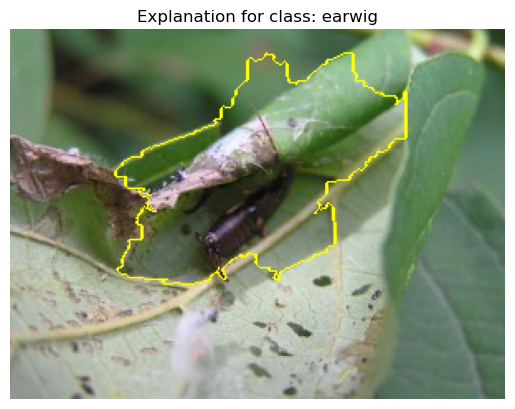

In [9]:
import numpy as np
import joblib
import torch
from torchvision import transforms
from torchvision.models import vit_b_16
from PIL import Image
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries  # For boundary visualization
import matplotlib.pyplot as plt

# Load the trained Random Forest model
model_path = 'H:/Deep Learning/Pest and Insect Detection/Vision Transformer integrated with ML models/ViT_RF_model.pkl'
rf_model = joblib.load(model_path)

# Load the pre-trained Vision Transformer model for feature extraction
vit_model = vit_b_16(pretrained=True)
vit_model.eval()

# Move the Vision Transformer model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

# Define the class names (ensure this is consistent with your dataset's classes)
class_names = ['ants', 'bees', 'beetle','caterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']  # Update as per your dataset

# Set up the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the input image
image_path = 'H:/Deep Learning/Pest and Insect Detection/Image Data/test/earwig/earwig (5).jpg'
original_image = Image.open(image_path).convert('RGB')
image_tensor = transform(original_image)  # Apply transformations

# Convert image to numpy format for LIME
image_np = np.array(original_image)

# Define a feature extraction function using Vision Transformer
def extract_features(images):
    """
    Extract features from images using Vision Transformer (ViT).
    """
    feature_list = []
    for img in images:
        # Convert image back to tensor
        img_pil = Image.fromarray(img)
        img_tensor = transform(img_pil).unsqueeze(0).to(device)  # Add batch dimension
        with torch.no_grad():
            features = vit_model(img_tensor)  # Extract features
        feature_list.append(features.cpu().numpy().flatten())  # Flatten features
    return np.array(feature_list)

# Define a prediction function for LIME
def predict_proba(images):
    """
    Prediction wrapper for the trained Random Forest model.
    Extracts features from images using ViT and predicts using RF.
    """
    features = extract_features(images)  # Extract features
    return rf_model.predict_proba(features)  # Predict probabilities using the Random Forest model

# Initialize LimeImageExplainer
explainer = LimeImageExplainer()

# Explain the instance using LIME
explanation = explainer.explain_instance(
    image_np, predict_proba, top_labels=5, hide_color=0, num_samples=1000
)

# Visualize explanation for the top predicted class
top_label = explanation.top_labels[0]
class_name = class_names[top_label]  # Map top_label to class_names
temp, mask = explanation.get_image_and_mask(
    top_label,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Display the image with explanations
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"Explanation for class: {class_name}")
plt.axis('off')
plt.show()


Predicted class: snail


  0%|          | 0/1000 [00:00<?, ?it/s]

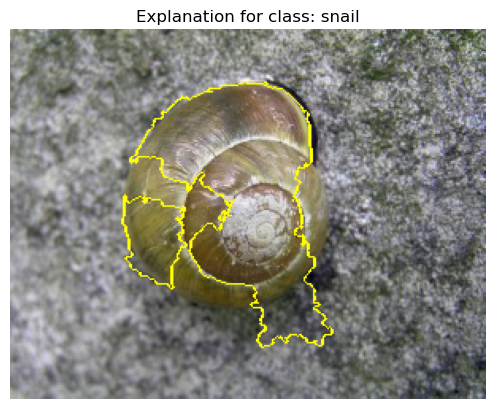

In [11]:
# Load the trained Random Forest model
model_path = 'H:/Deep Learning/Pest and Insect Detection/Vision Transformer integrated with ML models/ViT_RF_model.pkl'
rf_model = joblib.load(model_path)

# Load the pre-trained Vision Transformer model for feature extraction
vit_model = vit_b_16(pretrained=True)
vit_model.eval()

# Move the Vision Transformer model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

# Define the class names (ensure this is consistent with your dataset's classes)
class_names = ['ants', 'bees', 'beetle','caterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']  # Update as per your dataset

# Set up the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the input image
image_path = 'H:/Deep Learning/Pest and Insect Detection/Image Data/test/snail/snail (5).jpg'
original_image = Image.open(image_path).convert('RGB')
image_tensor = transform(original_image)  # Apply transformations

# Convert image to numpy format for LIME
image_np = np.array(original_image)

# Define a feature extraction function using Vision Transformer
def extract_features(images):
    """
    Extract features from images using Vision Transformer (ViT).
    """
    feature_list = []
    for img in images:
        # Convert image back to tensor
        img_pil = Image.fromarray(img)
        img_tensor = transform(img_pil).unsqueeze(0).to(device)  # Add batch dimension
        with torch.no_grad():
            features = vit_model(img_tensor)  # Extract features
        feature_list.append(features.cpu().numpy().flatten())  # Flatten features
    return np.array(feature_list)

# Define a prediction function for LIME
def predict_proba(images):
    """
    Prediction wrapper for the trained Random Forest model.
    Extracts features from images using ViT and predicts using RF.
    """
    features = extract_features(images)  # Extract features
    return rf_model.predict_proba(features)  # Predict probabilities using the Random Forest model

# Predict the class of the test image using the trained Random Forest model
image_features = extract_features([image_np])  # Extract features for the image
predicted_proba = rf_model.predict_proba(image_features)  # Get probabilities for each class
predicted_class_idx = np.argmax(predicted_proba)  # Get the class with the highest probability
predicted_class = class_names[predicted_class_idx]  # Get the class name

# Print the predicted class before LIME visualization
print(f"Predicted class: {predicted_class}")

# Initialize LimeImageExplainer
explainer = LimeImageExplainer()

# Explain the instance using LIME
explanation = explainer.explain_instance(
    image_np, predict_proba, top_labels=5, hide_color=0, num_samples=1000
)

# Visualize explanation for the top predicted class
top_label = explanation.top_labels[0]
class_name = class_names[top_label]  # Map top_label to class_names
temp, mask = explanation.get_image_and_mask(
    top_label,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Display the image with explanations
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"Explanation for class: {class_name}")
plt.axis('off')
plt.show()
